In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras 
from keras.layers import Input, Dense, Dropout, LSTM, ConvLSTM1D
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.layers import LeakyReLU
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import joblib
import wandb
from wandb.keras import WandbCallback

In [2]:
def rmse(pred, actual):
    error = np.subtract(pred, actual)
    sqerror= np.sum(np.square(error))/actual.shape[0]
    return np.sqrt(sqerror)

In [3]:
def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction,title="Graph"):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, history, label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()

In [4]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [5]:
df = pd.read_csv("../../data/data_processed_cleaned.csv")
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d %H:%M')

df['fve'] = df['fve'] * 0.05
df['mve'] = df['mve'] * 0.1
df['wpg'] = df['wpg'] * 0.1

df['production_usage'] = df['fve'] + df['mve'] + df['wpg'] 


df_test = pd.read_csv("../../data/data_processed_cleaned_fake.csv")
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y/%m/%d %H:%M')

In [6]:
features_considered = [
                    'price', 'isWeekend', 
                    'isHoliday',  'temp', 'wind','day_cos', 'day_sin',
                    'month_cos', 'month_sin'
                    ]
### Train dataset 
features = df[features_considered]
features.index = df['date']

scaler_prod = StandardScaler()
scaler_2 = MinMaxScaler()

prod_dataset = scaler_prod.fit_transform(df['production_usage'].values.reshape(-1,1))
prod_dataset = scaler_2.fit_transform(prod_dataset)

scaler_cons = StandardScaler()
scaler_2 = MinMaxScaler()
cons_dataset = scaler_cons.fit_transform(df['consumption_usage'].values.reshape(-1,1))
cons_dataset = scaler_2.fit_transform(cons_dataset)

scaler_all = StandardScaler()
scaler_2 = MinMaxScaler()
dataset = scaler_all.fit_transform(features.values)
dataset = scaler_2.fit_transform(features.values)

### Test dataset
features = df_test[features_considered]
features.index = df_test['date']

scaler_2 = MinMaxScaler()
scaler_prod = StandardScaler()
prod_dataset_test = scaler_prod.fit_transform(df_test['production_usage'].values.reshape(-1,1))
prod_dataset_test = scaler_2.fit_transform(prod_dataset_test)

scaler_2 = MinMaxScaler()
scaler_cons = StandardScaler()
cons_dataset_test = scaler_cons.fit_transform(df_test['consumption_usage'].values.reshape(-1,1))
cons_dataset_test = scaler_2.fit_transform(cons_dataset_test)

scaler_2 = MinMaxScaler()
dataset_test = scaler_all.fit_transform(features.values)
dataset_test = scaler_2.fit_transform(features.values)

In [7]:
print("X -> ",np.min(dataset), np.max(dataset), np.mean(dataset))
print("Y_production ->",np.min(prod_dataset), np.max(prod_dataset), np.mean(prod_dataset))
print("Y_consumption -> ",np.min(cons_dataset), np.max(cons_dataset), np.mean(cons_dataset))

X ->  0.0 1.0 0.39343083597275674
Y_production -> 0.0 1.0 0.31332284305813346
Y_consumption ->  0.0 1.0 0.2666621031566539


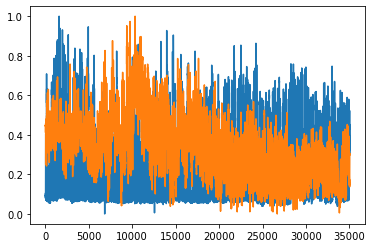

In [8]:
plt.plot(cons_dataset)
plt.plot(prod_dataset)

In [9]:
past_history = 96
future_target = 4
STEP = 1




x, y1 = multivariate_data(dataset, prod_dataset, 0,
                                                   None, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x, y2 = multivariate_data(dataset, cons_dataset, 0,
                                                   None, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val , y1_val = multivariate_data(dataset_test, prod_dataset_test,
                                               0, None, past_history,
                                               future_target, STEP,
                                               single_step=True)
x_val , y2_val = multivariate_data(dataset_test, cons_dataset_test,
                                               0, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [10]:
def get_model(convSize: int = 16, 
              dropOut: float = 0.2,
              lstm1Size : int=256,
              lstm2Size : int=128,
              leakyR1 : float = 0.1,
              leakyR2 : float = 0.1):
      
    inputs = Input(shape=(past_history,len(features_considered)))
    conv1 = Conv1D(convSize, kernel_size=4, activation='relu',name="CNN")(inputs)
    m = Dropout(dropOut,name="dropout")(conv1)
    pool1 = MaxPooling1D(pool_size=2)(m)
    m = LSTM(lstm1Size,  return_sequences=True,name="First_LSTM")(m)
    m = LSTM(lstm2Size,name="Second_LSTM")(m)
    outputA = Dense(future_target, activation=LeakyReLU(alpha=leakyR1))(m)
    outputB = Dense(future_target, activation=LeakyReLU(alpha=leakyR2))(m)
    m = Model(inputs=[inputs], outputs=[outputA, outputB])
    return m


In [11]:
def train(config: dict, 
          callbacks: list,
          verbose: int=0):

    # Initalize model
    tf.keras.backend.clear_session()
    model = get_model(config['convSize'],config['dropOut'],config['lstm1Size'],config['lstm2Size'],config['leakyR1'],config['leakyR2'])

    # Compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=config['init_learning_rate'])
    model.compile(opt,loss='mse')

    # Train the model
    _ = model.fit(x,[y1,y2],
                  epochs=config['epochs'],
                  steps_per_epoch=config['epochs_steps'],
                  callbacks=callbacks,
                  verbose=verbose)

    return model

In [12]:
import math
sweep_config = {
    'method': 'random'
    }
metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }
sweep_config['metric'] = metric

parameters_dict = {
    'dropOut': {
          'values': [0.1, 0.2,0.3, 0.4, 0.5]
        },
    'leakyR1': {
        'distribution': 'uniform',
        'min': 0,
        'max': 1
      },
    'leakyR2': {
        'distribution': 'uniform',
        'min': 0,
        'max': 1
      },
    'convSize': {
         'values': [16, 32,64]
      },
    'lstm1Size': {
        'values': [16, 32,64, 128, 256, 512]
      },
    'lstm2Size': {
         'values': [16, 32,64, 128, 256, 512]
      },
    'epochs': {
          'values': [10, 50,100, 200, 500]
          },
    'epochs_steps': {
        'values': [10, 100,200,500]
        },
    'init_learning_rate': {
        'distribution': 'uniform',
        'min': 0.001,
        'max': 0.1
      },
    }

sweep_config['parameters'] = parameters_dict

In [23]:
# %%time
# sweep_id = wandb.sweep(sweep_config, project="IITSRC-CNNLSTM-SWEEP")


# def trainSweep(config=None):
#     # Initialize a new wandb run
#     with wandb.init(config=config):
#         config = wandb.config

#         wandb_callback = WandbCallback(monitor='loss')

#         earlystopper = tf.keras.callbacks.EarlyStopping(
#             monitor='loss', patience=5, verbose=0, mode='auto',
#             restore_best_weights=True
#         )

#         # callbacks
#         callbacks = [earlystopper,wandb_callback]

#         # Train
#         model = train(config, callbacks=callbacks, verbose=1)

# wandb.agent(sweep_id, trainSweep, count=10)

# # Close the W&B run.
# wandb.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: c1w50gzo
Sweep URL: https://wandb.ai/ramang/IITSRC-CNNLSTM-SWEEP/sweeps/c1w50gzo


wandb: Agent Starting Run: 0vxxyzju with config:
wandb: 	convSize: 16
wandb: 	dropOut: 0.1
wandb: 	epochs: 100
wandb: 	epochs_steps: 200
wandb: 	init_learning_rate: 0.0974877881694782
wandb: 	leakyR1: 0.08635683664426896
wandb: 	leakyR2: 0.623471452160174
wandb: 	lstm1Size: 16
wandb: 	lstm2Size: 128


Epoch 1/100
200/200 [==============================] - 11s 46ms/step - loss: 1.3216 - dense_loss: 0.6557 - dense_1_loss: 0.6659 - _timestamp: 1648625316.0000 - _runtime: 15.0000
Epoch 2/100
200/200 [==============================] - 9s 44ms/step - loss: 0.0647 - dense_loss: 0.0272 - dense_1_loss: 0.0375 - _timestamp: 1648625325.0000 - _runtime: 24.0000
Epoch 3/100
200/200 [==============================] - 9s 43ms/step - loss: 0.0733 - dense_loss: 0.0312 - dense_1_loss: 0.0421 - _timestamp: 1648625333.0000 - _runtime: 32.0000
Epoch 4/100
200/200 [==============================] - 9s 43ms/step - loss: 0.0821 - dense_loss: 0.0337 - dense_1_loss: 0.0484 - _timestamp: 1648625342.0000 - _runtime: 41.0000
Epoch 5/100
200/200 [==============================] - 9s 43ms/step - loss: 0.3242 - dense_loss: 0.2635 - dense_1_loss: 0.0608 - _timestamp: 1648625350.0000 - _runtime: 49.0000
Epoch 6/100
200/200 [==============================] - 9s 43ms/step - loss: 0.2308 - dense_loss: 0.1225 - dense_1_

dense_1_loss,█▁▁▁▁▂▂
dense_loss,█▁▁▁▄▂▃
epoch,▁▂▃▅▆▇█
loss,█▁▁▁▂▂▂
best_epoch,1
best_loss,0.06468
dense_1_loss,0.10444
dense_loss,0.21155
epoch,6
loss,0.31599


wandb: Agent Starting Run: h2sv8d6r with config:
wandb: 	convSize: 64
wandb: 	dropOut: 0.2
wandb: 	epochs: 500
wandb: 	epochs_steps: 100
wandb: 	init_learning_rate: 0.07745337764605029
wandb: 	leakyR1: 0.3567370622902408
wandb: 	leakyR2: 0.7314499359257218
wandb: 	lstm1Size: 128
wandb: 	lstm2Size: 64


Epoch 1/500
100/100 [==============================] - 8s 60ms/step - loss: 0.7370 - dense_loss: 0.3623 - dense_1_loss: 0.3747 - _timestamp: 1648625390.0000 - _runtime: 11.0000
Epoch 2/500
100/100 [==============================] - 5s 52ms/step - loss: 0.0599 - dense_loss: 0.0251 - dense_1_loss: 0.0347 - _timestamp: 1648625396.0000 - _runtime: 17.0000
Epoch 3/500
100/100 [==============================] - 5s 54ms/step - loss: 0.0599 - dense_loss: 0.0251 - dense_1_loss: 0.0347 - _timestamp: 1648625401.0000 - _runtime: 22.0000
Epoch 4/500
100/100 [==============================] - 5s 54ms/step - loss: 0.0600 - dense_loss: 0.0252 - dense_1_loss: 0.0348 - _timestamp: 1648625407.0000 - _runtime: 28.0000
Epoch 5/500
100/100 [==============================] - 5s 53ms/step - loss: 0.0600 - dense_loss: 0.0253 - dense_1_loss: 0.0348 - _timestamp: 1648625412.0000 - _runtime: 33.0000
Epoch 6/500
100/100 [==============================] - 5s 53ms/step - loss: 0.0601 - dense_loss: 0.0252 - dense_1_l

dense_1_loss,█▁▁▁▁▁▁▁
dense_loss,█▁▁▁▁▁▁▁
epoch,▁▂▃▄▅▆▇█
loss,█▁▁▁▁▁▁▁
best_epoch,2
best_loss,0.05985
dense_1_loss,0.03484
dense_loss,0.02522
epoch,7
loss,0.06006


wandb: Agent Starting Run: 65mwzt21 with config:
wandb: 	convSize: 16
wandb: 	dropOut: 0.3
wandb: 	epochs: 50
wandb: 	epochs_steps: 100
wandb: 	init_learning_rate: 0.022961417989859463
wandb: 	leakyR1: 0.14322875683653324
wandb: 	leakyR2: 0.59221584673171
wandb: 	lstm1Size: 32
wandb: 	lstm2Size: 64


Epoch 1/50
100/100 [==============================] - 7s 51ms/step - loss: 0.1259 - dense_loss: 0.0630 - dense_1_loss: 0.0629 - _timestamp: 1648625447.0000 - _runtime: 10.0000
Epoch 2/50
100/100 [==============================] - 4s 45ms/step - loss: 0.0338 - dense_loss: 0.0192 - dense_1_loss: 0.0146 - _timestamp: 1648625452.0000 - _runtime: 15.0000
Epoch 3/50
100/100 [==============================] - 5s 45ms/step - loss: 0.0301 - dense_loss: 0.0165 - dense_1_loss: 0.0135 - _timestamp: 1648625456.0000 - _runtime: 19.0000
Epoch 4/50
100/100 [==============================] - 5s 45ms/step - loss: 0.0282 - dense_loss: 0.0148 - dense_1_loss: 0.0134 - _timestamp: 1648625461.0000 - _runtime: 24.0000
Epoch 5/50
100/100 [==============================] - 4s 45ms/step - loss: 0.0257 - dense_loss: 0.0127 - dense_1_loss: 0.0130 - _timestamp: 1648625465.0000 - _runtime: 28.0000
Epoch 6/50
100/100 [==============================] - 5s 45ms/step - loss: 0.0240 - dense_loss: 0.0114 - dense_1_loss: 0

dense_1_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
dense_loss,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,49
best_loss,0.01072
dense_1_loss,0.00581
dense_loss,0.00491
epoch,49
loss,0.01072


wandb: Agent Starting Run: n3j0c8ev with config:
wandb: 	convSize: 64
wandb: 	dropOut: 0.4
wandb: 	epochs: 500
wandb: 	epochs_steps: 100
wandb: 	init_learning_rate: 0.0535480984513583
wandb: 	leakyR1: 0.7457184092150879
wandb: 	leakyR2: 0.15008752373139833
wandb: 	lstm1Size: 32
wandb: 	lstm2Size: 512


Epoch 1/500
100/100 [==============================] - 16s 142ms/step - loss: 5.8477 - dense_loss: 3.1739 - dense_1_loss: 2.6738 - _timestamp: 1648625698.0000 - _runtime: 19.0000
Epoch 2/500
100/100 [==============================] - 14s 138ms/step - loss: 0.0679 - dense_loss: 0.0279 - dense_1_loss: 0.0399 - _timestamp: 1648625712.0000 - _runtime: 33.0000
Epoch 3/500
100/100 [==============================] - 14s 137ms/step - loss: 0.0680 - dense_loss: 0.0273 - dense_1_loss: 0.0407 - _timestamp: 1648625726.0000 - _runtime: 47.0000
Epoch 4/500
100/100 [==============================] - 14s 138ms/step - loss: 0.0722 - dense_loss: 0.0291 - dense_1_loss: 0.0431 - _timestamp: 1648625740.0000 - _runtime: 61.0000
Epoch 5/500
100/100 [==============================] - 14s 138ms/step - loss: 0.1197 - dense_loss: 0.0285 - dense_1_loss: 0.0912 - _timestamp: 1648625754.0000 - _runtime: 75.0000
Epoch 6/500
100/100 [==============================] - 14s 138ms/step - loss: 0.1269 - dense_loss: 0.0305

dense_1_loss,█▁▁▁▁▁▁
dense_loss,█▁▁▁▁▁▁
epoch,▁▂▃▅▆▇█
loss,█▁▁▁▁▁▁
best_epoch,1
best_loss,0.06787
dense_1_loss,0.05145
dense_loss,0.03115
epoch,6
loss,0.08259


wandb: Agent Starting Run: 598d50b0 with config:
wandb: 	convSize: 16
wandb: 	dropOut: 0.4
wandb: 	epochs: 10
wandb: 	epochs_steps: 500
wandb: 	init_learning_rate: 0.0917245239055075
wandb: 	leakyR1: 0.12697344446161463
wandb: 	leakyR2: 0.8136421105702603
wandb: 	lstm1Size: 128
wandb: 	lstm2Size: 512


Epoch 1/10
500/500 [==============================] - 31s 59ms/step - loss: 6.7907 - dense_loss: 3.3164 - dense_1_loss: 3.4743 - _timestamp: 1648625828.0000 - _runtime: 36.0000
Epoch 2/10
500/500 [==============================] - 29s 58ms/step - loss: 0.2240 - dense_loss: 0.1601 - dense_1_loss: 0.0639 - _timestamp: 1648625857.0000 - _runtime: 65.0000
Epoch 3/10
500/500 [==============================] - 29s 58ms/step - loss: 0.7209 - dense_loss: 0.5830 - dense_1_loss: 0.1380 - _timestamp: 1648625886.0000 - _runtime: 94.0000
Epoch 4/10
500/500 [==============================] - 29s 58ms/step - loss: 1.5245 - dense_loss: 1.1484 - dense_1_loss: 0.3762 - _timestamp: 1648625915.0000 - _runtime: 123.0000
Epoch 5/10
500/500 [==============================] - 29s 58ms/step - loss: 1.6439 - dense_loss: 1.2274 - dense_1_loss: 0.4165 - _timestamp: 1648625944.0000 - _runtime: 152.0000
Epoch 6/10
500/500 [==============================] - 29s 58ms/step - loss: 2.0920 - dense_loss: 1.6673 - dense_1

dense_1_loss,█▁▁▂▂▂▂
dense_loss,█▁▂▃▃▄▄
epoch,▁▂▃▅▆▇█
loss,█▁▂▂▃▃▃
best_epoch,1
best_loss,0.22401
dense_1_loss,0.40804
dense_loss,1.33112
epoch,6
loss,1.73916


wandb: Agent Starting Run: e99svvm2 with config:
wandb: 	convSize: 32
wandb: 	dropOut: 0.1
wandb: 	epochs: 200
wandb: 	epochs_steps: 100
wandb: 	init_learning_rate: 0.05196887662456335
wandb: 	leakyR1: 0.7081444584639173
wandb: 	leakyR2: 0.4272471076087123
wandb: 	lstm1Size: 256
wandb: 	lstm2Size: 512
wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)


Epoch 1/200
100/100 [==============================] - 21s 191ms/step - loss: 7.2953 - dense_loss: 3.8096 - dense_1_loss: 3.4856 - _timestamp: 1648626045.0000 - _runtime: 25.0000
Epoch 2/200
100/100 [==============================] - 19s 186ms/step - loss: 0.3025 - dense_loss: 0.0359 - dense_1_loss: 0.2666 - _timestamp: 1648626063.0000 - _runtime: 43.0000
Epoch 3/200
100/100 [==============================] - 19s 186ms/step - loss: 0.5281 - dense_loss: 0.2214 - dense_1_loss: 0.3066 - _timestamp: 1648626082.0000 - _runtime: 62.0000
Epoch 4/200
100/100 [==============================] - 22s 217ms/step - loss: 0.1968 - dense_loss: 0.0446 - dense_1_loss: 0.1522 - _timestamp: 1648626104.0000 - _runtime: 84.0000
Epoch 5/200
100/100 [==============================] - 20s 195ms/step - loss: 0.4860 - dense_loss: 0.2185 - dense_1_loss: 0.2675 - _timestamp: 1648626123.0000 - _runtime: 103.0000
Epoch 6/200
100/100 [==============================] - 23s 232ms/step - loss: 0.5818 - dense_loss: 0.294

dense_1_loss,█▁▁▁▁▁▂▁▁
dense_loss,█▁▁▁▁▁▁▁▁
epoch,▁▂▃▄▅▅▆▇█
loss,█▁▁▁▁▁▁▁▁
best_epoch,3
best_loss,0.19683
dense_1_loss,0.13887
dense_loss,0.20376
epoch,8
loss,0.34263


wandb: Agent Starting Run: ub8puwwq with config:
wandb: 	convSize: 32
wandb: 	dropOut: 0.3
wandb: 	epochs: 10
wandb: 	epochs_steps: 200
wandb: 	init_learning_rate: 0.04138891957720906
wandb: 	leakyR1: 0.11666228172342884
wandb: 	leakyR2: 0.44703681391525174
wandb: 	lstm1Size: 64
wandb: 	lstm2Size: 512


Epoch 1/10
200/200 [==============================] - 20s 92ms/step - loss: 3.4131 - dense_loss: 1.4999 - dense_1_loss: 1.9133 - _timestamp: 1648626347.0000 - _runtime: 24.0000
Epoch 2/10
200/200 [==============================] - 18s 88ms/step - loss: 0.1481 - dense_loss: 0.0728 - dense_1_loss: 0.0753 - _timestamp: 1648626364.0000 - _runtime: 41.0000
Epoch 3/10
200/200 [==============================] - 18s 89ms/step - loss: 0.1311 - dense_loss: 0.0700 - dense_1_loss: 0.0611 - _timestamp: 1648626382.0000 - _runtime: 59.0000
Epoch 4/10
200/200 [==============================] - 18s 88ms/step - loss: 0.1530 - dense_loss: 0.0980 - dense_1_loss: 0.0550 - _timestamp: 1648626400.0000 - _runtime: 77.0000
Epoch 5/10
200/200 [==============================] - 18s 88ms/step - loss: 0.2001 - dense_loss: 0.1439 - dense_1_loss: 0.0562 - _timestamp: 1648626417.0000 - _runtime: 94.0000
Epoch 6/10
200/200 [==============================] - 18s 88ms/step - loss: 0.1714 - dense_loss: 0.1191 - dense_1_l

dense_1_loss,█▁▁▁▁▁▁▁
dense_loss,█▁▁▁▁▁▁▁
epoch,▁▂▃▄▅▆▇█
loss,█▁▁▁▁▁▁▁
best_epoch,2
best_loss,0.13115
dense_1_loss,0.06816
dense_loss,0.12981
epoch,7
loss,0.19798


wandb: Agent Starting Run: nru5n5mb with config:
wandb: 	convSize: 32
wandb: 	dropOut: 0.1
wandb: 	epochs: 10
wandb: 	epochs_steps: 500
wandb: 	init_learning_rate: 0.029651383146088124
wandb: 	leakyR1: 0.5727842726806684
wandb: 	leakyR2: 0.7628510898193691
wandb: 	lstm1Size: 128
wandb: 	lstm2Size: 128


Epoch 1/10
500/500 [==============================] - 25s 46ms/step - loss: 0.1178 - dense_loss: 0.0538 - dense_1_loss: 0.0640 - _timestamp: 1648626510.0000 - _runtime: 29.0000
Epoch 2/10
500/500 [==============================] - 22s 44ms/step - loss: 0.0730 - dense_loss: 0.0309 - dense_1_loss: 0.0420 - _timestamp: 1648626532.0000 - _runtime: 51.0000
Epoch 3/10
500/500 [==============================] - 22s 44ms/step - loss: 0.0739 - dense_loss: 0.0314 - dense_1_loss: 0.0425 - _timestamp: 1648626554.0000 - _runtime: 73.0000
Epoch 4/10
500/500 [==============================] - 22s 44ms/step - loss: 0.0720 - dense_loss: 0.0300 - dense_1_loss: 0.0421 - _timestamp: 1648626576.0000 - _runtime: 95.0000
Epoch 5/10
500/500 [==============================] - 22s 44ms/step - loss: 0.0724 - dense_loss: 0.0302 - dense_1_loss: 0.0422 - _timestamp: 1648626598.0000 - _runtime: 117.0000
Epoch 6/10
500/500 [==============================] - 22s 44ms/step - loss: 0.0716 - dense_loss: 0.0298 - dense_1_

dense_1_loss,█▁▁▁▁▁▁▁▂▁
dense_loss,█▁▁▁▁▁▂▁▂▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁▁▁▁▁▁▁▂▁
best_epoch,5
best_loss,0.07163
dense_1_loss,0.04131
dense_loss,0.0304
epoch,9
loss,0.07171


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m94d08jq with config:
wandb: 	convSize: 16
wandb: 	dropOut: 0.4
wandb: 	epochs: 10
wandb: 	epochs_steps: 10
wandb: 	init_learning_rate: 0.08915811915870911
wandb: 	leakyR1: 0.17912456317979775
wandb: 	leakyR2: 0.33168723275508494
wandb: 	lstm1Size: 32
wandb: 	lstm2Size: 128


Epoch 1/10
10/10 [==============================] - 10s 835ms/step - loss: 17.2019 - dense_loss: 7.7172 - dense_1_loss: 9.4847 - _timestamp: 1648626741.0000 - _runtime: 14.0000
Epoch 2/10
10/10 [==============================] - 8s 820ms/step - loss: 8.1228 - dense_loss: 4.5931 - dense_1_loss: 3.5298 - _timestamp: 1648626749.0000 - _runtime: 22.0000
Epoch 3/10
10/10 [==============================] - 8s 818ms/step - loss: 2.4006 - dense_loss: 1.5021 - dense_1_loss: 0.8985 - _timestamp: 1648626757.0000 - _runtime: 30.0000
Epoch 4/10
10/10 [==============================] - 8s 817ms/step - loss: 0.9108 - dense_loss: 0.4236 - dense_1_loss: 0.4872 - _timestamp: 1648626765.0000 - _runtime: 38.0000
Epoch 5/10
10/10 [==============================] - 8s 816ms/step - loss: 0.5094 - dense_loss: 0.2942 - dense_1_loss: 0.2151 - _timestamp: 1648626773.0000 - _runtime: 46.0000
Epoch 6/10
10/10 [==============================] - 8s 816ms/step - loss: 0.2917 - dense_loss: 0.1694 - dense_1_loss: 0.122

dense_1_loss,█▄▂▁▁▁▁▁▁▁
dense_loss,█▅▂▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▂▁▁▁▁▁▁▁
best_epoch,9
best_loss,0.06412
dense_1_loss,0.03613
dense_loss,0.02799
epoch,9
loss,0.06412


wandb: Agent Starting Run: b0jq1jfo with config:
wandb: 	convSize: 32
wandb: 	dropOut: 0.5
wandb: 	epochs: 200
wandb: 	epochs_steps: 100
wandb: 	init_learning_rate: 0.08126521553178577
wandb: 	leakyR1: 0.2085147003403789
wandb: 	leakyR2: 0.1819012891724613
wandb: 	lstm1Size: 32
wandb: 	lstm2Size: 128


Epoch 1/200
100/100 [==============================] - 7s 57ms/step - loss: 1.1017 - dense_loss: 0.5506 - dense_1_loss: 0.5511 - _timestamp: 1648626835.0000 - _runtime: 11.0000
Epoch 2/200
100/100 [==============================] - 5s 49ms/step - loss: 0.0642 - dense_loss: 0.0276 - dense_1_loss: 0.0367 - _timestamp: 1648626840.0000 - _runtime: 16.0000
Epoch 3/200
100/100 [==============================] - 5s 50ms/step - loss: 0.0665 - dense_loss: 0.0272 - dense_1_loss: 0.0393 - _timestamp: 1648626845.0000 - _runtime: 21.0000
Epoch 4/200
100/100 [==============================] - 5s 49ms/step - loss: 0.0662 - dense_loss: 0.0282 - dense_1_loss: 0.0380 - _timestamp: 1648626850.0000 - _runtime: 26.0000
Epoch 5/200
100/100 [==============================] - 5s 50ms/step - loss: 0.0678 - dense_loss: 0.0283 - dense_1_loss: 0.0395 - _timestamp: 1648626855.0000 - _runtime: 31.0000
Epoch 6/200
100/100 [==============================] - 5s 48ms/step - loss: 0.0782 - dense_loss: 0.0363 - dense_1_l

dense_1_loss,█▁▁▁▁▁▁
dense_loss,█▁▁▁▁▁▁
epoch,▁▂▃▅▆▇█
loss,█▁▁▁▁▁▁
best_epoch,1
best_loss,0.06422
dense_1_loss,0.04213
dense_loss,0.02908
epoch,6
loss,0.07121


CPU times: user 15min 35s, sys: 5min 7s, total: 20min 43s
Wall time: 26min 13s


In [17]:
inputs = Input(shape=(past_history,len(features_considered)))
conv1 = Conv1D(16, kernel_size=4, activation='relu',name="CNN")(inputs)
m = Dropout(0.2,name="dropout")(conv1)
pool1 = MaxPooling1D(pool_size=2)(m)
m = LSTM(512,  return_sequences=True,name="First_LSTM")(m)
m = LSTM(32,name="Second_LSTM")(m)
outputA = Dense(future_target, activation=LeakyReLU(alpha=0.3347),name="Consumption_Dense")(m)
outputB = Dense(future_target, activation=LeakyReLU(alpha=0.24),name="Production_Dense")(m)
m = Model(inputs=[inputs], outputs=[outputA, outputB])
opt = tf.keras.optimizers.Adam(learning_rate=0.0039460)
m.compile(opt,loss='mse')
# m.compile(optimizer='adam', loss='mse')
# history = m.fit(x,[y1,y2], epochs=50,steps_per_epoch=200)

#restore the model file "model.h5" from a specific run by user "lavanyashukla"
#in project "save_and_restore" from run "10pr4joa"
best_model = wandb.restore('model-best.h5', run_path="ramang/IITSRC-CNNLSTM-SWEEP/runs/hsddzyc3")

# use the "name" attribute of the returned object if your framework expects a filename, e.g. as in Keras
m.load_weights(best_model.name)

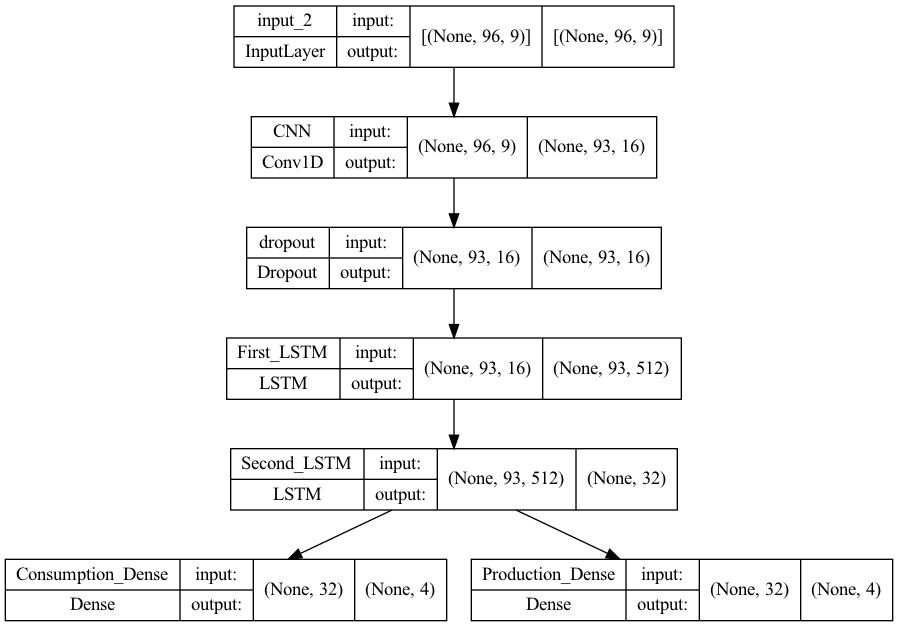

In [18]:
from keras.utils.vis_utils import plot_model
plot_model(m, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [54]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [19]:
m.save("CNNLST_SWEEP.h5")

<ipython-input-20-621f5b6c8295>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  actual = np.array(actual)


Average rmse
[[0.09951344]
 [0.10047511]
 [0.10408844]
 [0.10980622]]


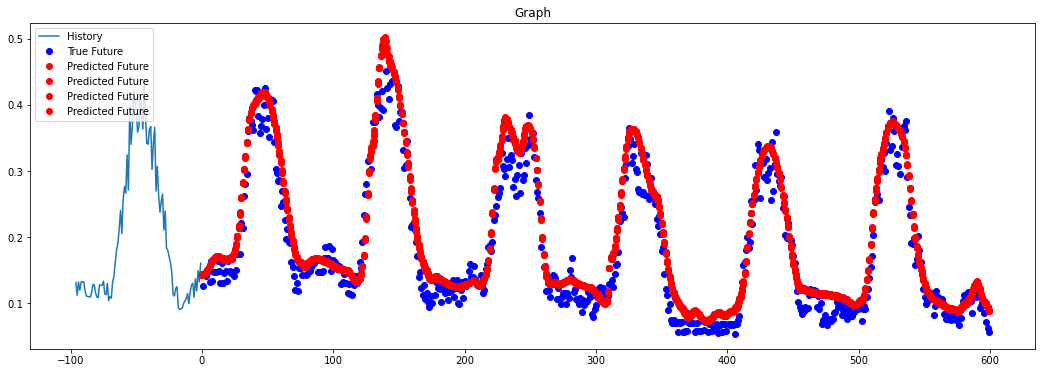

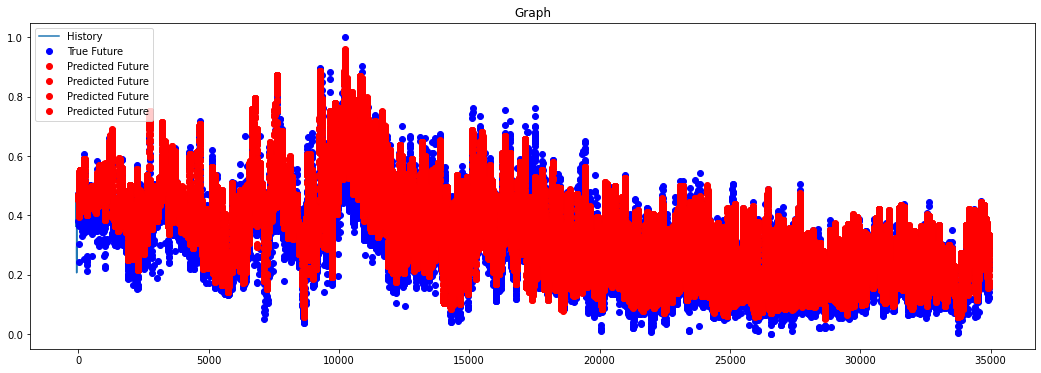

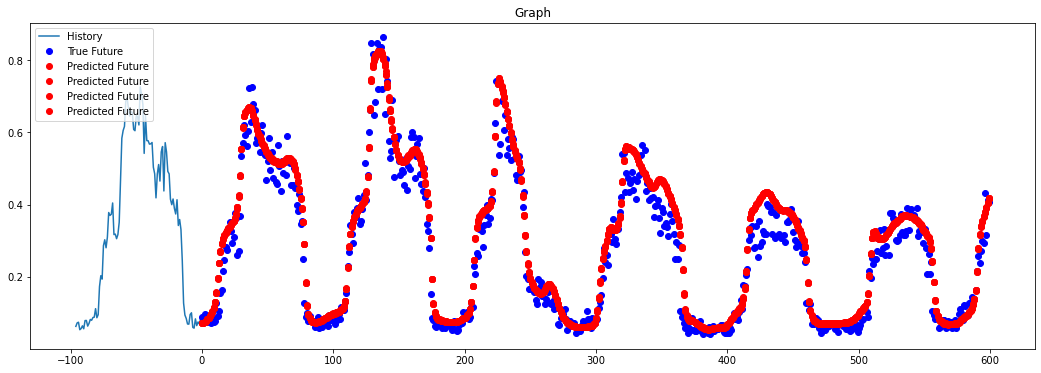

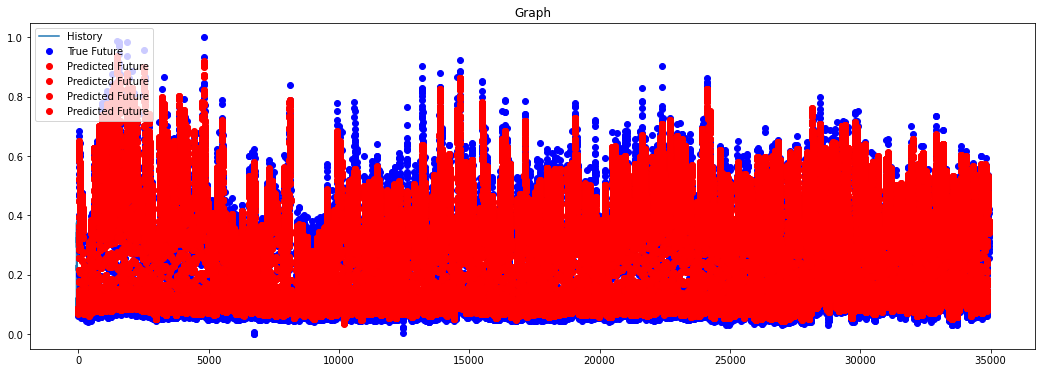

In [20]:
pred = m.predict(x_val)
actual = []
for index,val in enumerate(y1_val):
    actual.append([y1_val[index:index+future_target]])
actual = np.array(actual)
print("Average rmse")
print(rmse(pred[0][:-future_target],actual[:-future_target]))

multi_step_plot(prod_dataset_test[24000:][:96], y1_val[24000:][:600], pred[0][24000:][:600])
multi_step_plot(prod_dataset_test[:96], y1_val, pred[0])
multi_step_plot(cons_dataset_test[24000:][:96], y2_val[24000:][:600], pred[1][24000:][:600])
multi_step_plot(cons_dataset_test[:96], y2_val, pred[1])